### Metadata
- Commenter name (e.g., Center for AI Policy)
- NTIA commenter ID (e.g., NTIA-2023-0009-0264)
- Organization vs individual commenter
- Alias for visualization (e.g., CAIP)

In [2]:
import pandas as pd

metadata = pd.read_json("comment_metadata.json") 
metadata = metadata[metadata['is_org'] == True].reset_index(drop=True)
metadata.sort_values(by=['Commenter']).head(10)

,Commenter,ID,is_org,Alias
27,ACT | The App Association,NTIA-2023-0009-0282,True,The App
51,"AH Capital Management, L.L.C. (""a16z"")",NTIA-2023-0009-0252,True,a16z
32,AI & Democracy Foundation,NTIA-2023-0009-0290,True,AI & Democracy
5,AI Policy and Governance Working Group,NTIA-2023-0009-0257,True,AIPGWG
46,Access Now,NTIA-2023-0009-0242,True,Access Now
0,Alliance for Trust in AI,NTIA-2023-0009-0156,True,Alliance for Trust in AI
52,"American Civil Liberties Union, Center for Ame...",NTIA-2023-0009-0263,True,ACLU
1,Anthropic PBC,NTIA-2023-0009-0233,True,Anthropic
33,Association for Long Term Existence and Resili...,NTIA-2023-0009-0301,True,ALTER
9,BSA The Software Alliance,NTIA-2023-0009-0155,True,BSA


In [3]:
metadata.shape # 51 organizations + 1 individual

(53, 4)

### Load text data

- Text output after converting original documents in PDF to text using `pymupdf`. 

In [4]:
import os

texts = []

for filename in os.listdir('texts/'):
    if filename.endswith('.txt'):
        file_path = os.path.join('texts/', filename)
        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read()
            texts.append({'ID': filename.replace('.txt', ''), 'text': content})

df = pd.DataFrame(texts)

# append alias to the dataframe
id_to_commenter = dict(zip(metadata['ID'], metadata['Alias']))
df['Commenter_alias'] = df['ID'].map(id_to_commenter)

df.head()

,ID,text,Commenter_alias
0,NTIA-2023-0009-0155,\n \n \nNational Telecommunications and Infor...,BSA
1,NTIA-2023-0009-0223,8605 Santa Monica Blvd PMB 63639\nWest Hollywo...,Open Source Initiative
2,NTIA-2023-0009-0180,"\n \n \n \n \n600 14th St. NW, Suite 300 \nWa...",IBM
3,NTIA-2023-0009-0142,\n \n \n \n \n \n \nComment on “NTIA AI Open ...,Unlearn.AI
4,NTIA-2023-0009-0156,"Alliance for Trust in AI, comments on NTIA Ope...",Alliance for Trust in AI


In [5]:
# show all pandas rows
# show all pandas columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [6]:
from dotenv import load_dotenv
load_dotenv()

import openai
openai.api_key = os.getenv("OPENAI_API_KEY")

### Calculate number of tokens per text document

In [7]:
import tiktoken

embedding_model = "text-embedding-3-large"
embedding_encoding = "cl100k_base"
encoding = tiktoken.get_encoding(embedding_encoding)

df["n_tokens"] = df.text.apply(lambda x: len(encoding.encode(x)))
df["n_tokens"].size, df["n_tokens"].max(), df["n_tokens"].min(), df["n_tokens"].median()

(52, 51351, 1045, 6217.0)

<Axes: >

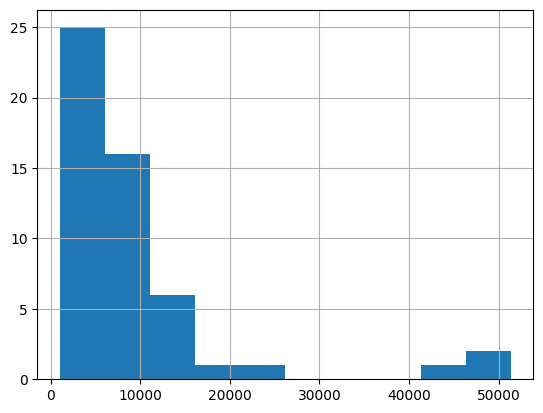

In [8]:
df["n_tokens"].hist(bins=10)

In [9]:
df[['Commenter_alias', 'n_tokens']].sort_values(by=['n_tokens'], ascending=False).head(10)   

,Commenter_alias,n_tokens
45,CDT,51351
39,Centre for the Governance of AI,47656
49,EPIC,41946
50,Meta,22124
25,EleutherAI,16755
24,a16z,14906
41,GitHub,13574
31,FLI,12974
37,Hugging Face,12216
16,Context Fund,12157


### Create embeddings

- Token counts for most documents exceed the maximum token count
- Split documents into smaller chunks, compute embeddings for each chunk, and then average the embeddings to get a single embedding for the document

In [12]:
%%time
import numpy as np

documents = df['text'].tolist()

def create_embeddings(documents, max_tokens=8000):
    embeddings = []
    for doc in documents:
        chunks = [doc[i:i+max_tokens] for i in range(0, len(doc), max_tokens)]
        chunk_embeddings = [openai.Embedding.create(input=chunk, engine=embedding_model)['data'][0]['embedding'] for chunk in chunks]
        doc_embedding = np.mean(chunk_embeddings, axis=0)  # Average chunk embeddings (try something else?)
        embeddings.append(doc_embedding)
    return embeddings

embeddings = create_embeddings(documents)

CPU times: user 1.71 s, sys: 234 ms, total: 1.94 s
Wall time: 1min 28s


In [13]:
# check if embedding size is correct (should be 3072 for large model)
# see https://openai.com/blog/new-embedding-models-and-api-updates
len(embeddings), len(embeddings[0])

(52, 3072)

In [14]:
df.to_csv('ntia-dataset-with-embeddings.csv', index=False, header=True)

### Plot the embeddings using PCA

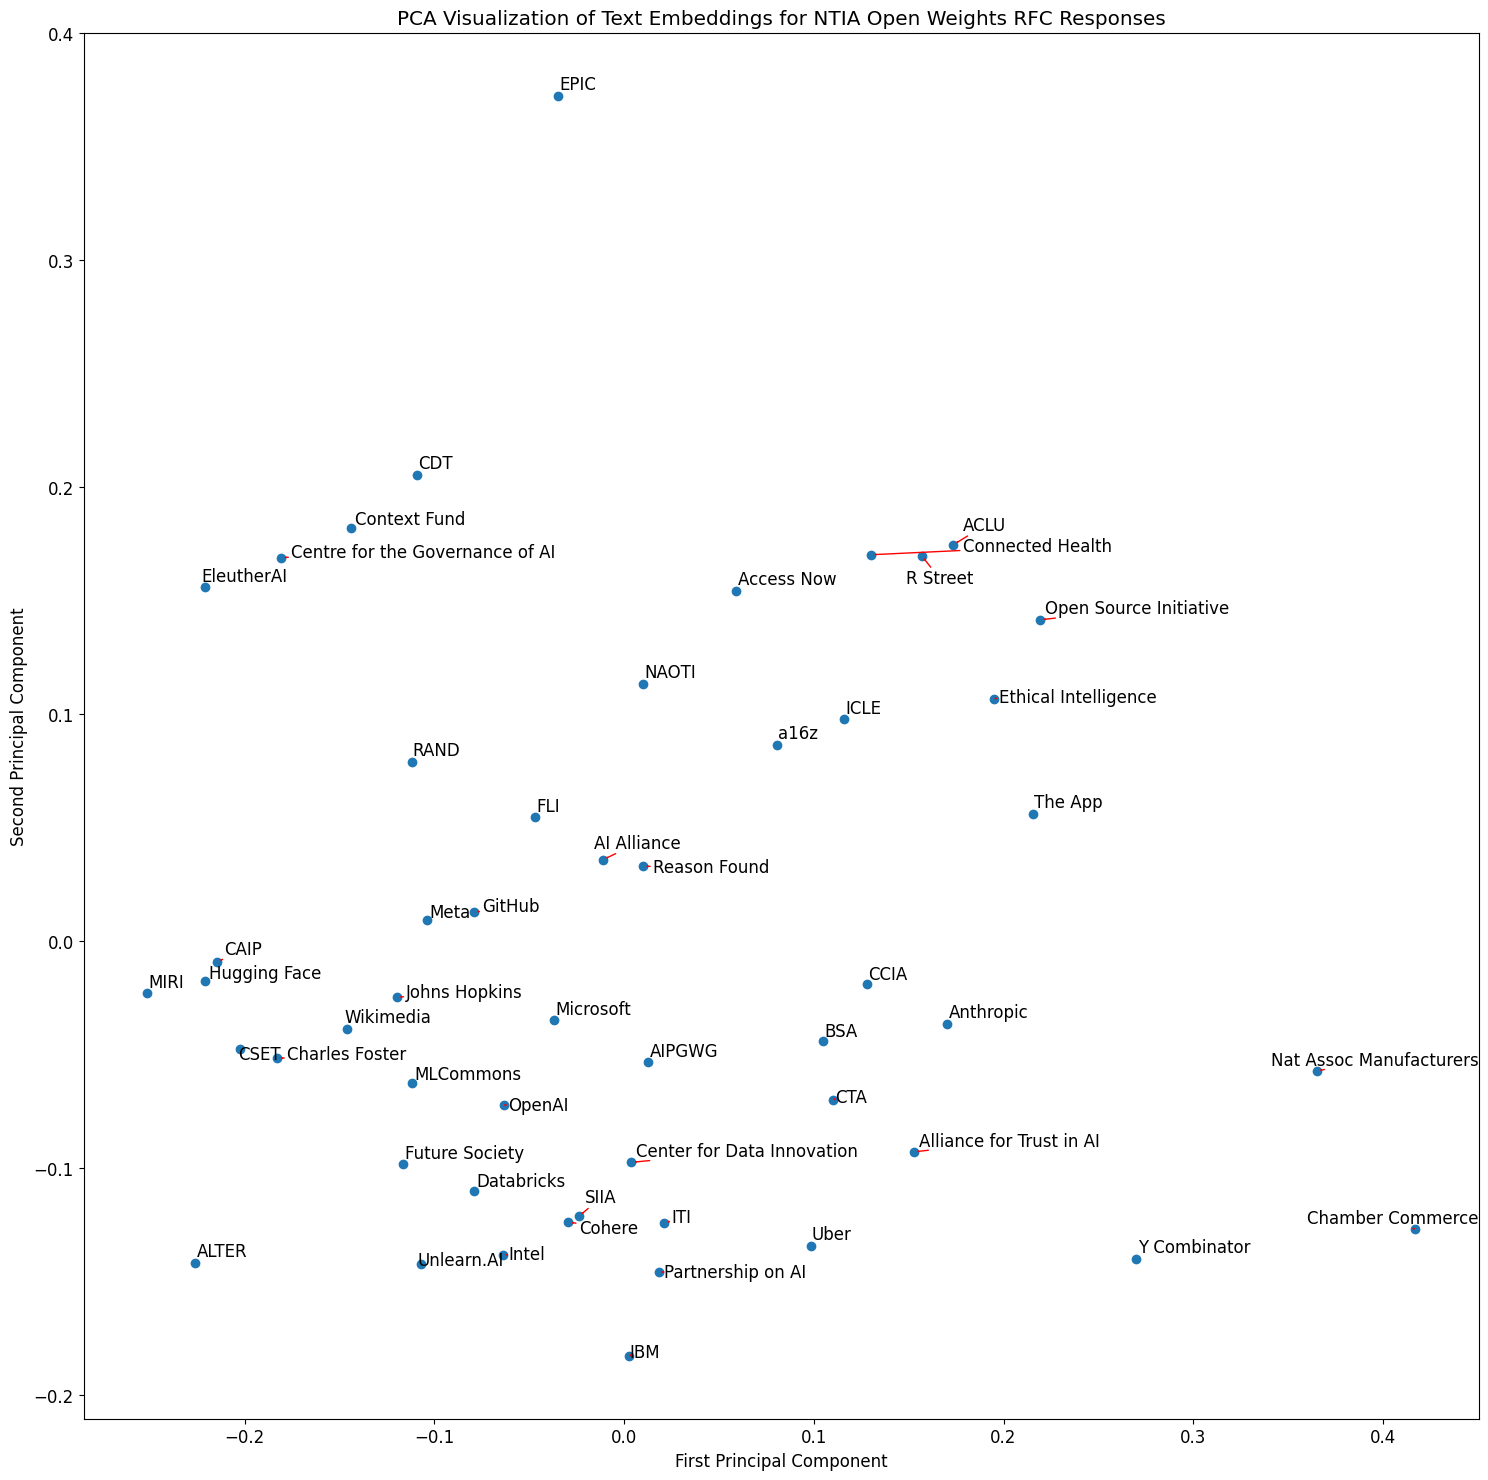

In [44]:
import matplotlib.pyplot as plt
from adjustText import adjust_text
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(embeddings)

plt.rcParams['font.size'] = 12
plt.figure(figsize=(18, 18))
plt.scatter(pca_embeddings[:, 0], pca_embeddings[:, 1]) 
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

# plot labels for each document using the aliases (abbreviated commenter names)
labels = df['Commenter_alias'].tolist()

texts = []
for i, label in enumerate(labels):
    texts.append(plt.text(pca_embeddings[i, 0], pca_embeddings[i, 1], label))

adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))

plt.title('PCA Visualization of Text Embeddings for NTIA Open Weights RFC Responses')
plt.show()
#plt.savefig('pca_visualization.png', dpi=300)